
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 畳み込みネットワーク アーキテクチャの設計

:label: `sec_cnn-design`

これまでのセクションでは、コンピューター ビジョンのための最新のネットワーク設計について説明しました。私たちが取り上げたすべての研究に共通するのは、科学者の直観に大きく依存しているということです。アーキテクチャの多くは、人間の創造性によって大きく影響を受けていますが、ディープ ネットワークが提供する設計空間の体系的な探索による影響ははるかに少ないです。それにもかかわらず、この*ネットワーク エンジニアリングの*アプローチは大きな成功を収めています。

 AlexNet (:numref: `sec_alexnet` ) が ImageNet 上の従来のコンピューター ビジョン モデルを打ち破って以来、すべて同じパターンで設計された畳み込みブロックを積み重ねることによって非常に深いネットワークを構築することが普及しました。特に、$3 \times 3$ 畳み込みは VGG ネットワーク (:numref: `sec_vgg` ) によって普及しました。 NiN (:numref: `sec_nin` ) は、$1 \times 1$ の畳み込みでも、局所的な非線形性を追加することで有益になる可能性があることを示しました。さらに、NiN は、すべての場所にわたる集約によって、ネットワークの先頭に情報を集約するという問題を解決しました。 GoogLeNet (:numref: `sec_googlenet` ) は、Inception ブロックで VGG と NiN の利点を組み合わせて、異なる畳み込み幅の複数のブランチを追加しました。 ResNets (:numref: `sec_resnet` ) は、アイデンティティ マッピングに対する帰納的バイアスを変更しました ($f(x) = 0$ から)。これにより、非常に深いネットワークが可能になりました。ほぼ 10 年が経った今でも、ResNet 設計は依然として人気があり、その証拠はその設計です。最後に、ResNeXt (:numref: `subsec_resnext` ) はグループ化された畳み込みを追加し、パラメーターと計算の間のより良いトレードオフを提供します。 Transformers for Vision の前身である Squeeze-and-Excitation Networks (SENet) により、場所間の効率的な情報転送が可能になります (引用: `Hu.Shen.Sun.2018` )。彼らは、チャネルごとのグローバル アテンション関数を計算することでこれを実現しました。

これまでのところ、*ニューラル アーキテクチャ検索*(NAS) :cite: `zoph2016neural,liu2018darts`によって取得されたネットワークは省略しました。ブルート フォース検索、遺伝的アルゴリズム、強化学習、またはその他の形式のハイパーパラメータ最適化に依存すると、コストが通常膨大になるため、このようにすることにしました。固定の検索スペースが与えられると、NAS は検索戦略を使用して、返されたパフォーマンス推定に基づいてアーキテクチャを自動的に選択します。 NAS の結果は単一のネットワーク インスタンスです。 EfficientNet は、この検索の注目すべき結果です :cite: `tan2019efficientnet` 。

以下では、*単一の最適なネットワーク*の探求とはまったく異なるアイデアについて説明します。これは計算コストが比較的低く、途中で科学的洞察につながり、結果の質の点で非常に効果的です。*ネットワーク設計空間を設計する*ための :citet: `Radosavovic.Kosaraju.Girshick.ea.2020`による戦略を確認してみましょう。この戦略は、手動設計と NAS の長所を組み合わせたものです。これは、*ネットワークのディストリビューション*を操作し、ネットワーク ファミリ全体で良好なパフォーマンスが得られるようにディストリビューションを最適化することによって実現されます。その成果は、 *RegNets* 、具体的には RegNetX と RegNetY に加えて、パフォーマンスの高い CNN の設計のためのさまざまな指針となります。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## AnyNet 設計空間

:label: `subsec_the-anynet-design-space`

以下の説明は、:citet: `Radosavovic.Kosaraju.Girshick.ea.2020`の推論に厳密に従っており、本の範囲に収まるようにいくつかの略語が含まれています。まず、探索するネットワーク ファミリのテンプレートが必要です。この章の設計の共通点の 1 つは、ネットワークが*ステム*、*ボディ*、*ヘッド*で構成されていることです。ステムは、多くの場合、より大きなウィンドウ サイズでの畳み込みを通じて初期画像処理を実行します。本体は複数のブロックで構成され、生の画像からオブジェクト表現に移行するために必要な変換の大部分を実行します。最後に、ヘッドは、マルチクラス分類のためのソフトマックス リグレッサーなどを介して、これを目的の出力に変換します。本体は複数のステージで構成され、解像度を下げて画像を処理します。実際、ステムと後続の各ステージの両方で空間解像度が 4 分の 1 になります。最後に、各ステージは 1 つ以上のブロックで構成されます。このパターンは、VGG から ResNeXt までのすべてのネットワークに共通です。実際、汎用 AnyNet ネットワークの設計では、 :citet: `Radosavovic.Kosaraju.Girshick.ea.2020`は :numref: `fig_resnext_block`の ResNeXt ブロックを使用しました。 

![](http://d2l.ai/_images/anynet.svg) :ラベル: `fig_anynet_full`

 :numref: `fig_anynet_full`で概説されている構造を詳しく見てみましょう。前述したように、AnyNet はステム、ボディ、ヘッドで構成されます。ステムは、入力 RGB 画像 (3 チャネル) を取り、$2$ のストライドで $3 \times 3$ 畳み込みを使用し、その後にバッチ ノルムを使用して、解像度を $r \times r$ から $r/2 に半分にします。 \×r/2$。さらに、本体への入力として機能する $c_0$ チャネルを生成します。

ネットワークは $224 \times 224 \times 3$ の形状の ImageNet 画像をうまく処理できるように設計されているため、本体は 4 つのステージを通じてこれを $7 \times 7 \times c_4$ に減らす役割を果たします ($224 / 2^{1+ を思い出してください) 4} = 7$)、それぞれの最終的なストライドは $2$ になります。最後に、ヘッドは、NiN (:numref: `sec_nin` ) と同様のグローバル平均プーリングを介した完全な標準設計を採用し、その後に完全に接続された層が $n$ クラス分類用の $n$ 次元ベクトルを出力します。

関連する設計上の決定のほとんどは、ネットワーク本体に固有のものです。これは段階的に進行し、各段階は :numref: `subsec_resnext`で説明したのと同じタイプの ResNeXt ブロックで構成されます。ここでも設計は完全に汎用的です。$2$ のストライドを使用して解像度を半分にするブロックから始めます (:numref: `fig_anynet_full`の右端)。これに一致させるには、ResNeXt ブロックの残差ブランチは $1 \times 1$ 畳み込みを通過する必要があります。このブロックの後には、解像度とチャンネル数の両方を変更しない、可変数の追加 ResNeXt ブロックが続きます。一般的な設計手法では、畳み込みブロックの設計にわずかなボトルネックを追加することに注意してください。そのため、ボトルネック比率 $k_i \geq 1$ を使用すると、ステージ $i$ の各ブロック内にある程度の数のチャネル $c_i/k_i$ を確保できます (実験が示すように、これは実際には効果的ではないため、スキップする必要があります)。最後に、ResNeXt ブロックを扱っているため、ステージ $i$ でグループ化された畳み込みのグループ $g_i$ の数を選択する必要もあります。

この一見一般的な設計空間では、多くのパラメーターが提供されます。ブロック幅 (チャネル数) $c_0、\ldots c_4$、ステージごとの深さ (ブロック数) $d_1、\ldots d_4$、ボトルネックを設定できます。比率 $k_1、\ldots k_4$、およびグループ幅 (グループの数) $g_1、\ldots g_4$。合計で最大 17 個のパラメータが追加されるため、調査する必要がある不当に多数の設定が必要になります。この巨大な設計スペースを効果的に削減するには、いくつかのツールが必要です。ここで、デザイン空間の概念的な美しさが登場します。その前に、まず一般的なデザインを実装しましょう。


In [2]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())


各ステージは`depth` ResNeXt ブロックで構成され、 `num_channels`ブロック幅を指定します。最初のブロックは入力画像の高さと幅を半分にすることに注意してください。


In [3]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)


ネットワークのステム、ボディ、ヘッドを組み合わせると、AnyNet の実装が完成します。


In [4]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)


## 設計空間の分布とパラメータ

:numref: `subsec_the-anynet-design-space`で説明したように、設計空間のパラメータは、その設計空間内のネットワークのハイパーパラメータです。 AnyNet 設計空間で適切なパラメータを特定する問題を考えてみましょう。与えられた計算量 (FLOP や計算時間など) に対して、*単一の最適な*パラメーターの選択を見つけることもできます。各パラメータに対して可能な選択肢が*2 つ*だけしか許可されていない場合、最適な解決策を見つけるには $2^{17} = 131072$ の組み合わせを探索する必要があります。これは法外なコストがかかるため、明らかに実行不可能です。さらに悪いことに、ネットワークをどのように設計すべきかという点では、この演習からは実際には何も学べません。次回、たとえば X ステージやシフト操作などを追加するときは、最初から開始する必要があります。さらに悪いことに、トレーニングの確率論 (丸め、シャッフル、ビット エラー) により、2 回の実行でまったく同じ結果が得られる可能性は高くありません。より良い戦略は、パラメーターの選択をどのように関連させるかについての一般的なガイドラインを決定することです。たとえば、ボトルネック率、チャネル、ブロック、グループの数、またはレイヤー間のそれらの変更は、理想的には単純なルールの集合によって管理される必要があります。 :citet: `radosavovic2019network`のアプローチは、次の 4 つの前提に基づいています。
1. これらの要件を満たす多くのネットワークは良好なパフォーマンスを提供するはずであるという一般的な設計原則が実際に存在すると仮定します。したがって、ネットワーク上の*配布*を特定することは良い戦略となり得ます。言い換えれば、干し草の山の中に良い針がたくさんあると仮定します。
1. ネットワークが良好かどうかを評価する前に、ネットワークを収束するようにトレーニングする必要はありません。代わりに、最終的な精度の信頼できる指針として中間結果を使用するだけで十分です。 (近似) プロキシを使用して目標を最適化することは、マルチ忠実度の最適化と呼ばれます:cite: `forrester2007multi` 。その結果、データセットを数回通過しただけで達成される精度に基づいて設計の最適化が実行され、コストが大幅に削減されます。
1. より小さいスケール (小規模なネットワーク) で得られた結果は、より大規模なネットワークに一般化されます。その結果、構造的に類似しているが、ブロック数やチャネル数が少ないネットワークに対して最適化が実行されます。最終的にのみ、そのようにして見つかったネットワークが大規模でも優れたパフォーマンスを提供することを検証する必要があります。
1. 設計の側面はほぼ因数分解できるため、結果の品質に対するそれらの影響をある程度独立して推測できるようになります。つまり、最適化問題は中程度に簡単です。

これらの仮定により、多くのネットワークを安価にテストできるようになります。特に、構成の空間から均一に*サンプリングして*、そのパフォーマンスを評価できます。その後、上記のネットワークで達成できる誤差/精度の*分布*をレビューすることで、パラメータの選択の品質を評価できます。 $F(e)$ は、確率分布 $p$ を使用して描画された、特定の設計空間のネットワークによって発生する誤差の累積分布関数 (CDF) を示します。あれは、

 $$F(e, p) \stackrel{\mathrm{def}}{=} P_{\mathrm{net} \sim p} {e(\mathrm{net}) \leq e}.$$

私たちの目標は、ほとんどのネットワークでエラー率が非常に低く、$p$ のサポートが簡潔であるような*ネットワーク*上で $p$ の分布を見つけることです。もちろん、これを正確に実行することは計算上不可能です。ネットワーク $\mathcal{Z} \stackrel{\mathrm{def}}{=} {\mathrm{net}_1, \ldots \mathrm{net}_n}$ のサンプルを使用します (エラー $e_1, \ $p$ からそれぞれ ldots、e_n$) を取得し、代わりに経験的 CDF $\hat{F}(e, \mathcal{Z})$ を使用します。

 $$\hat{F}(e, \mathcal{Z}) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(e_i \leq e).$$

ある選択セットの CDF が別の CDF を優越する (または一致する) 場合は常に、そのパラメーターの選択が優れている (または無関係である) ことになります。したがって、:citet: `Radosavovic.Kosaraju.Girshick.ea.2020` 、ネットワークのすべてのステージ $i$ に対して、共有ネットワークのボトルネック比率 $k_i = k$ を実験しました。これにより、ボトルネック比率を支配する $4$ パラメーターのうち $3$ が削除されます。これがパフォーマンスに（マイナスの）影響を与えるかどうかを評価するには、制約のある分布と制約のない分布からネットワークを描画し、対応する CDF を比較します。 :numref: `fig_regnet-fig`の最初のパネルに見られるように、この制約はネットワークの分布の精度にまったく影響を及ぼさないことがわかります。同様に、ネットワークのさまざまな段階で発生する同じグループ幅 $g_i = g$ を選択することもできます。 :numref: `fig_regnet-fig`の 2 番目のパネルに見られるように、これはパフォーマンスには影響しません。両方の手順を組み合わせると、自由パラメータの数が $6$ 減少します。 

![](../img/regnet-fig.png) :label: `fig_regnet-fig`

次に、ステージの幅と深さの潜在的な選択肢を減らす方法を探します。より深く進むにつれて、チャネルの数が増加するはずである、つまり、:numref の表記に従って $c_i \geq c_{i-1}$ ($w_{i+1} \geq w_i$) が増加するはずであるというのは合理的な仮定です。 `fig_regnet-fig` )、$\text{AnyNetX} *D$ が生成されます。同様に、ステージが進むにつれてステージが深くなり、$d_i \geq d {i-1}$ となり、$\text{AnyNetX}_E$ が得られると仮定することも同様に合理的です*。これは、 :numref: `fig_regnet-fig`の 3 番目と 4 番目のパネルでそれぞれ実験的に検証できます。

##  RegNet

結果として得られる $\text{AnyNetX}_E$ 設計空間は、解釈しやすい設計原則に従った単純なネットワークで構成されます。
- すべてのステージ $i$ でボトルネック比率 $k_i = k$ を共有します。
- すべてのステージ $i$ でグループ幅 $g_i = g$ を共有します。
- ステージ全体のネットワーク幅を増やします: $c_{i} \leq c_{i+1}$;
- ステージ全体でネットワークの深さを増やします: $d_{i} \leq d_{i+1}$。

これにより、最終的な $\text{AnyNetX}_E$ 設計空間の上記パラメータの特定の値を選択する方法という最後の選択肢が残ります。 $\text{AnyNetX}_E$ の分布から最もパフォーマンスの高いネットワークを調べると、次のことが観察できます。ネットワークの幅は、理想的にはネットワーク全体のブロック インデックスに応じて線形に増加します。つまり、$c_j \およそ c_0 + c_a j $、ここで $j$ はブロック インデックスであり、傾きは $c_a &gt; 0$ です。ステージごとにのみ異なるブロック幅を選択できることを考慮すると、この依存関係に一致するように設計された区分定数関数に到達します。第 2 に、ボトルネック比率 $k = 1$ が最もパフォーマンスが良いことも実験で示されています。つまり、ボトルネックをまったく使用しないことをお勧めします。

興味のある読者は、:citet: `Radosavovic.Kosaraju.Girshick.ea.2020`を熟読して、さまざまな計算量に合わせて特定のネットワークを設計する方法の詳細を確認することをお勧めします。たとえば、効果的な 32 層 RegNetX バリアントは、最初のチャネルの $k = 1$ (ボトルネックなし)、$g = 16$ (グループ幅は 16)、$c_1 = 32$、および $c_2 = 80$ チャネルによって与えられます。第 2 ステージは、それぞれ $d_1=4$ ブロックと $d_2=6$ ブロックの深さに選択されます。この設計から得られる驚くべき洞察は、より大規模なネットワークを調査する場合にも適用できるということです。さらに良いことに、グローバル チャネル アクティベーションを持つスクイーズ アンド 励起 (SE) ネットワーク設計 (RegNetY) にも当てはまります (引用: `Hu.Shen.Sun.2018` )。


In [5]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)


RegNetX の各ステージでは、解像度が徐々に低下し、出力チャネルが増加していることがわかります。


In [6]:
RegNetX32().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 32, 48, 48])


Sequential output shape:	 torch.Size([1, 32, 24, 24])


Sequential output shape:	 torch.Size([1, 80, 12, 12])
Sequential output shape:	 torch.Size([1, 10])



## トレーニング

Fashion-MNIST データセットでの 32 層 RegNetX のトレーニングは、以前とまったく同じです。


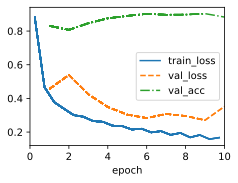

In [7]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)


## 議論

視覚に対する局所性や変換不変性 (:numref: `sec_why-conv` ) などの望ましい帰納的バイアス (仮定または好み) を備えた CNN は、この分野で支配的なアーキテクチャとなってきました。これは、LeNet 以来、トランスフォーマー (:numref: `sec_transformer` ) :cite: `Dosovitskiy.Beyer.Kolesnikov.ea.2021,touvron2021training`が精度の点で CNN を超え始めた最近まで当てはまります。ビジョン トランスフォーマーに関する最近の進歩の多くは CNN にバックポート*できます*:cite: `liu2022convnet` 、それはより高い計算コストが必要になります。同様に重要なことは、最近のハードウェアの最適化 (NVIDIA Ampere と Hopper) により、Transformers に有利な差が広がるだけであるということです。

 Transformer は、局所性と変換の不変性に対する帰納的バイアスの度合いが CNN よりも大幅に低いことは注目に値します。それは少なくとも、構造を学習した最大 50 億枚の画像を含む LAION-400m や LAION-5B :cite: `schuhmann2022laion`などの大規模な画像コレクションが利用できるためです。まったく驚くべきことに、この文脈においてより関連性の高い研究には、MLP も含まれています (cite: `tolstikhin2021mlp` )。

要約すると、ビジョン トランスフォーマー (:numref: `sec_vision-transformer` ) は現在、大規模な画像分類における最先端のパフォーマンスの点でリードしており、*スケーラビリティが帰納的バイアスに勝る*ことを示しています :cite: `Dosovitskiy.Beyer.Kolesnikov.ea.2021` · 。これには、マルチヘッド セルフ アテンション (:numref: sec_multihead- `sec_multihead-attention` `sec_large-pretraining-transformers` ) の事前トレーニングが含まれます。読者の皆様には、さらに詳細な議論を行うためにこれらの章に進んでいただくようお勧めします。

## 演習
1. ステージ数を 4 に増やします。よりパフォーマンスの高い、より深い RegNetX を設計できますか?
1.  ResNeXt ブロックを ResNet ブロックに置き換えることにより、RegNet を非 ResNeXt 化します。新しいモデルのパフォーマンスはどうですか?
1.  RegNetX の設計原則に*違反して*、「VioNet」ファミリーの複数のインスタンスを実装します。彼らはどのようにパフォーマンスを行うのでしょうか？ ($d_i$、$c_i$、$g_i$、$b_i$) のどれが最も重要な要素ですか?
1. あなたの目標は、「完璧な」MLP を設計することです。上で紹介した設計原則を使用して、優れたアーキテクチャを見つけることができますか?小規模ネットワークから大規模ネットワークまで推定することは可能ですか?



[ディスカッション](https://discuss.d2l.ai/t/7463)
